# Cvičenie 10: Hebbovo učenie

Pri trénovaní neurónových sietí je vždy kľúčová otázka spôsob aktualizácie váh. Najčastejšie sa na to použije algoritmus backpropagation alebo niektorý z jeho variantov. Algoritmus je síce účinný a zjednodušuje spôsob trénovania neurónových sietí, má niekoľko nedostatkov a tým hlavným je to, že váhy sa aktualizujú postupne z posledných vrstiev smerom ku vstupnej vrstve. Moderné výpočtové zdroje umožňujú paralelizovať niektoré výpočty, ale efektivita trénovania stále nepribližuje k teoretickým maximálnym možnostiam.

Dnes uvidíme, ako funguje alternatívny spôsob aktualizácie váh neurónov, ktorý je založený na teórii učenia biologických neurónov - Hebbovo učenie. Hebbovo učenie sa aplikuje pri nekontrolovanom učení a jeden z najčastejších prípadov použitia je analýza hlavných komponentov, teda získanie prvotných informácií o datasete. Na dnešnom cvičení Hebbovo učenie použijeme na získanie vlastných vektorov nejakej množiny dát.

## 1. Vlastné hodnoty a vlastné vektory

Vlastný vektor (*eigenvector*) je určený pre lineárny operátor, ktorý keď aplikujeme, smer vlastného vektoru sa nemení, mení sa iba jeho veľkosť - vektor teda meníme iba násobkom skalárneho čísla. Vlastná hodnota (*eigenvalue*) je číslo, ktorým potrebujeme násobiť vlastný vektor pri aplikácii operátora.

Pre datasety majú vlastné vektory ešte jeden špeciálny význam: sú výstupom analýzy hlavných komponentov. Cieľom takejto analýzy je nájsť množinu kombinácií pôvodných príznakov, ktorá zachováva najväčšie množstvo informácií a zároveň má menej dimenzií ako pôvodná množina príznakov. S vlastnými vektormi to súvisí tak, že vlastný vektor kovariančnej matice popisuje zároveň aj hlavné komponenty.

### 1.1. Generovanie datasetu

Aby sme poukázali na všeobecnosť Hebbovho učenia, nepoužijeme statický dataset, ale náhodne ho vygenerujeme pomocou knižnice `scikit-learn`. Aj keď generovanie bude náhodné, nastavíme niekoľko parametrov aby sme zabezpečili opakovateľnosť našich pokusov.

Najprv si naimportujeme všetky potrebné moduly:

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

Knižnice `numpy` a `matplotlib` už poznáte, a niektoré prvky sme už použili aj zo `scikit-learn`. Dnes najprv použijeme metódu `make_blobs`, ktorá nám vygeneruje náhodné body na základe istých nastavení, a triedu `StandardScaler`, ktorá slúži na škálovanie údajov tak, že vymaže priemerné hodnoty a upraví príznaky na jednotkovú varianciu.

In [2]:
np.random.seed(1000)

X, _ = make_blobs(
    n_samples=500,
    centers=2,  # príznaky (x, y)
    cluster_std=5.0,
    random_state=420)

Metóda `make_blobs` nám vygeneruje náhodné body, ktoré zorganizuje do zhlukov. Keďže my ale pracujeme s nekontrolovaným učením, očakávané výstupy (zhluky) nepoužijeme. Pri volaní funkcie nastavíme počet vygenerovaných bodov (`n_samples=500`), počet centier zhlukov (`centers=2`), štandardnú deviáciu jednotlivých zhlukov (`cluster_std=5.0`) a nastavíme aj generovanie náhodných čísel pre generovanie bodov (`random_state=1000`). Podrobný popis týchto parametrov nájdete v [dokumentácii](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

### 1.2. Úprava dát

Po vygenerovaní datasetu potrebujeme ho ešte upraviť a prvou úlohou je škálovanie údajov pomocou už spomínaného `StandardScaler`. Podrobný popis triedy nájdete znova v [dokumentácii](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [3]:
scaler = StandardScaler(with_std=False)
Xs = scaler.fit_transform(X)

### 1.3. Výpočet vlastnej hodnoty a vlastných vektorov

Ďalšou úlohou je výpočet vlastných vektorov, ktoré potom chceme aproximovať pomocou Hebbovho učenia. Pre výpočet týchto vektorov najprv určíme [kovariančnú maticu](https://datascienceplus.com/understanding-the-covariance-matrix/) (pomocou knižnice `numpy`) a následne určíme vlastnú hodnotu a vlastný vektor.

In [4]:
Q = np.cov(Xs.T)
print(Q)

eigu, eigv = np.linalg.eig(Q)
print(eigu)
print(eigv)

[[26.22982054  3.52954435]
 [ 3.52954435 34.90907643]]
[24.97569715 36.16319982]
[[-0.94228425 -0.33481396]
 [ 0.33481396 -0.94228425]]


In [5]:
i = 1
print(np.dot(Q, eigv[:, i]))
print(eigu[i] * eigv[:, i])

[-12.10794417 -34.07601369]
[-12.10794417 -34.07601369]


In [6]:
np.dot(Xs, eigv[:, :]).shape

(500, 2)

Kód by mal vygenerovať dve hodnoty a dva vektory, pričom vektory sa vypisujú v stĺpcoch. Hebbovo učenie nám pomôže pri získaní toho hlavného komponentu, teda vektoru s vyššou vlastnou hodnotou (v našom prípade je to druhý vektor `[-0.6528286, -0.75750566]`).

Vektory vieme vizualizovať aj pomocou `matplotlib`:

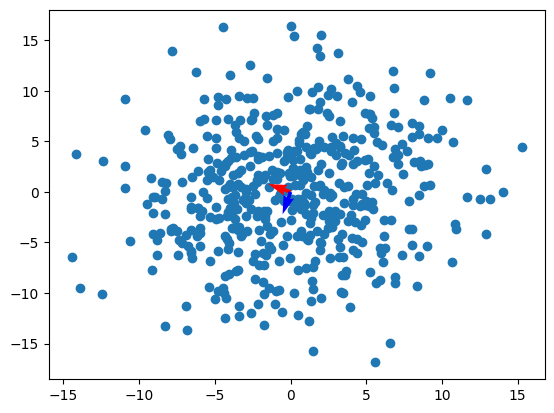

In [7]:
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.quiver(*[0, 0], *eigv[:, 0], color=['r'], scale=21)
plt.quiver(*[0, 0], *eigv[:, 1], color=['b'], scale=21)
plt.show()

## 2. Hebbovo učenie

Hebbovo učenie je model učenia biologických neurónov, ktorý vymyslel Donald Hebb v roku 1949. Jeho aplikácia v trénovaní umelých neurónových sietí má jednoznačnú výhodu oproti backpropagation v tom, že aktualizácia váh závisí iba od predsynaptického a postsynaptického neurónu, teda aktualizáciu vieme úplne paralelizovať, nemusíme vypočítať chybové signály pre každý neurón postupne. 

Hebbovo učenie zavedie aj ďalšie zjednodušenia do modelu neurónu, z ktorých hlavný je zmazanie prahu (vieme ho ale reprezentovať ako váha nultého vstupu). Takisto nemáme aktivačnú a výstupnú funkciu, tým pádom výstup sa vypočíta iba ako skalárny súčin dvoch vektorov:

$y=\sum_{i=1}^{n} w_{i} x_{i}$

Samotné trénovanie je založené na jednoduchom princípe: ak pred- a postsynaptické neuróny sa správajú rovnakým spôsobom (teda ich výstupy majú rovnaké znamienka), zosilníme synapsiu, v opačnom prípade hodnotu váhy znížime (*neurons that fire together, wire together*). Formálne to vieme napísať nasledovne:

$\Delta w_{i} = \gamma x_{i} y$,

kde $\gamma$ je učiaci parameter.

Aktualizačné pravidlo pre implementáciu umelej neurónovej siete sformuloval Erkki Oja:

$\Delta w_{i} = \gamma y (x_{i} - w_{i}y)$

### 2.1. Implementácia Hebbovho učenia pre jeden neurón

V tomto kroku implementujeme Hebbovo učenie pomocou Ojovho pravidla pre jeden neurón. Použijeme pritom dataset vygenerovaný v predošlom kroku, teda s dvoma príznakmi a jedným výstupom. Váhy neurónu by mali konvergovať ku prvotnému vlastnému vektoru.

Najprv váhy nainicializujeme náhodne a nainicializujeme aj premennú pre uchovávanie predošlých hodnôt váh (pre určenie konvergencie):

In [8]:
W_oja = np.random.normal(scale=0.25, size=(2, 1))
prev_W_oja = np.ones((2, 1))

Ďalej nastavíme parametre učenia: učiaci parameter a toleranciu, ktorá slúži na určenie miery konvergencie. Trénovanie potom ukončíme ak zmena váh je menšia ako tolerancia.

In [9]:
learning_rate = 0.0001
tolerance = 1e-8

### 2.2. Trénovanie neurónu

Počas trénovania použijeme Ojovo pravidlo. Neurčíme počet epoch, ale ukončovaciu podmienku pre mieru zmeny váh (tolerancia). Samotný učiaci proces vieme vyjadriť nasledovne:

In [10]:
while np.linalg.norm(W_oja - prev_W_oja) > tolerance:
    prev_W_oja = W_oja.copy()
    for x in Xs:
        y = np.dot(x, W_oja)
        dW_oja = learning_rate * y * (x - W_oja.T * y).reshape((2, 1))
        W_oja += dW_oja

### 2.3. Vizualizácia výsledku

Vlastný vektor nájdeme vo váhach ako stĺpec, preto ho najprv pretransformujeme na riadky a zoberieme prvý člen:

In [11]:
oja_vec = W_oja.T[0]
print(oja_vec)
print(eigv[:, 1])

[0.34077077 0.94084574]
[-0.33481396 -0.94228425]


Ako vidíme, hodnoty vo vektore sú blízko druhému stĺpcovému vektoru v premennej `eigv`. Vektor aj dataset následne vizualizujeme pomocou `matplotlib`:

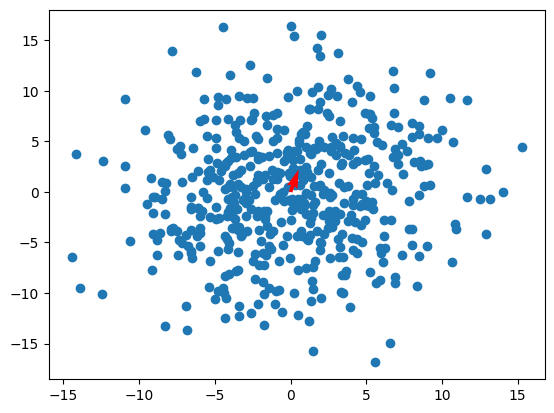

In [12]:
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.quiver(*[0, 0], *oja_vec, color=['r'], scale=21)
plt.show()

## 3. Sangerovo pravidlo

Zovšeobecnený Hebbov algoritmus, ktorý umožňuje trénovanie sietí aj s viacerými výstupmi, sa riadi Sangerovým pravidlom:

$\Delta w_{ij} = \gamma (y_{i}x_{j} - y_{i}\sum_{k=1}^{i}w_{kj}y_{k})$

a pre vektorovú formu:

$\Delta \bar{w} = \gamma (\bar{y} \cdot \bar{x}^{T} - tril(\bar{y} \cdot \bar{y}^{T}) \cdot \bar{w})$

In [13]:
W_sanger = np.random.normal(scale=0.1, size=(2, 2))
prev_W_sanger = np.ones((2, 2))

learning_rate = 0.1
nb_iterations = 2000
t = 0.0

for i in range(nb_iterations):
    prev_W_sanger = W_sanger.copy()
    dw = np.zeros((2, 2))
    t += 1.0

    for j in range(Xs.shape[0]):
        Ysj = np.dot(W_sanger, Xs[j]).reshape((2, 1))
        QYd = np.tril(np.dot(Ysj, Ysj.T))
        dw += np.dot(Ysj, Xs[j].reshape((1, 2))) - np.dot(QYd, W_sanger)

    W_sanger += (learning_rate / t) * dw  # be more precise after every iter
    W_sanger /= np.linalg.norm(W_sanger, axis=1).reshape((2, 1))

print(W_sanger)

[[ 0.33481396  0.94228425]
 [-0.94228425  0.33481396]]


Kódy a riešenia nájdete tu [Ojovo pravidlo](https://github.com/DominikVranay/neural-networks-course/blob/d7f75c66a45050db3c064842172e28f844e6786f/labs/sources/lab10/lab10-oja-solution.py) a [Sangerovo pravidlo](https://github.com/DominikVranay/neural-networks-course/blob/d7f75c66a45050db3c064842172e28f844e6786f/labs/sources/lab10/lab10-sanger-solution.py).